In [2]:
#@title
import tensorflow as tf
from typing import Tuple

def small_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: str = 'relu') -> tf.keras.models.Sequential:
  """Setup a small CNN for image classification.

  Args:
    input_shape: Integer tuple for the shape of the images.
    num_classes: Number of prediction classes.
    num_conv: Number of convolutional layers.
    activation: The activation function to use for conv and dense layers.

  Returns:
    The Keras model.
  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))
  
  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

  return model

2024-05-27 10:44:01.662806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
import tensorflow_privacy.privacy.optimizers
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer
import tensorflow_privacy.privacy.optimizers.dp_optimizer

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Convert class vectors to binary class matrices
y_train_bin = tf.keras.utils.to_categorical(y_train, 10)
y_test_bin = tf.keras.utils.to_categorical(y_test, 10)

input_shape = X_train.shape[1:]

batch_size=50
num_classes = 10
activation = 'relu'
num_conv = 3
lr = 0.001
total_epochs = 2

assert X_train.shape[0] % batch_size == 0, "The tensorflow_privacy optimizer doesn't handle partial batches"

print("\n input_shape - ", input_shape)

model_2layers = small_cnn(
    input_shape, num_classes, num_conv=2, activation=activation)

history = model_2layers.fit(
      X_train,
      y_train_bin,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(X_test, y_test_bin),
      shuffle=True)



 input_shape -  (32, 32, 3)
Epoch 1/2
1000/1000 [==============================] - 15s 14ms/step - loss: 1.5581 - accuracy: 0.4381 - val_loss: 1.3579 - val_accuracy: 0.5155
Epoch 2/2
1000/1000 [==============================] - 16s 16ms/step - loss: 1.2137 - accuracy: 0.5708 - val_loss: 1.1256 - val_accuracy: 0.6056


313/313 [==============================] - 2s 7ms/step


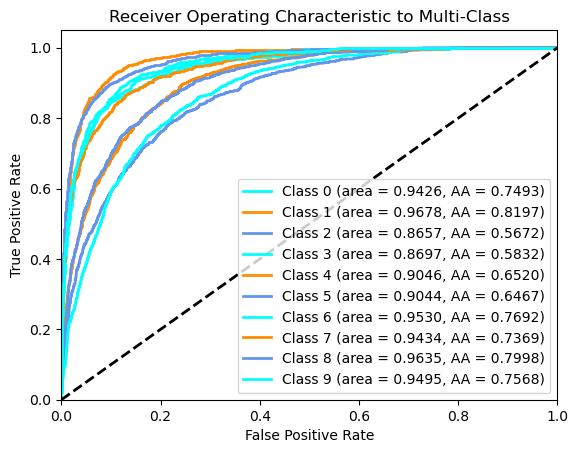

Attacker Advantage for class 0: 0.7493333333333333
Attacker Advantage for class 1: 0.8196666666666668
Attacker Advantage for class 2: 0.5672222222222223
Attacker Advantage for class 3: 0.5832222222222222
Attacker Advantage for class 4: 0.652
Attacker Advantage for class 5: 0.6466666666666666
Attacker Advantage for class 6: 0.7692222222222223
Attacker Advantage for class 7: 0.7368888888888889
Attacker Advantage for class 8: 0.7997777777777778
Attacker Advantage for class 9: 0.7567777777777778


In [10]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Get the probabilities of the positive class
y_scores = model_2layers.predict(X_test)

y_scores_list = [row for row in y_scores]

# Step 2: Apply softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

y_probs = np.array([softmax(row) for row in y_scores_list])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
attacker_advantage = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calculate Attacker Advantage for each class
    attacker_advantage[i] = max(tpr[i] - fpr[i])
# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (area = {1:0.4f}, AA = {2:0.4f})'
             ''.format(i, roc_auc[i], attacker_advantage[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()

# Print Attacker Advantage for each class
for i in range(n_classes):
    print(f"Attacker Advantage for class {i}: {attacker_advantage[i]}")